In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine

# Load the wine dataset into a DataFrame
df_wine = load_wine(as_frame=True)
df_wine = df_wine.frame
df_wine.columns = [ 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity',
                   'Hue', 'OD280/OD315 of diluted wines',
                   'Proline', 'Class label']

df_wine.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
X = df_wine.iloc[:, :-1].values 
y = df_wine.iloc[:, -1].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state= 1) 

sc = StandardScaler() 
X_train_std = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [3]:
np.set_printoptions(precision=4) 
mean_vecs = [] 

for label in range(len(np.unique(y_test))): 
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0)) 
    print(f'Mean Value{label}\n : {mean_vecs[label-1]}')

Mean Value0
 : [ 0.8998 -0.36    0.301  -0.743   0.4679  0.9176  0.9809 -0.6287  0.6403
  0.2018  0.4958  0.7642  1.1697]
Mean Value1
 : [ 0.8998 -0.36    0.301  -0.743   0.4679  0.9176  0.9809 -0.6287  0.6403
  0.2018  0.4958  0.7642  1.1697]
Mean Value2
 : [-0.9191 -0.3613 -0.367   0.2926 -0.4362 -0.1187  0.0098  0.1098 -0.0235
 -0.8556  0.372   0.2343 -0.7699]


In [4]:
d = 13 
s_w = np.zeros((d, d))
for label, mv in zip(range(len(np.unique(y_test))), mean_vecs): 
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]: 
        row, mv = row.reshape((d, 1)), mv.reshape((d, 1)) 
        class_scatter += (row - mv).dot((row - mv).T) 
    s_w += class_scatter 

print('Within-class scatter matrix\n', 
         f'{s_w.shape[0]}x{s_w.shape[1]}') 
    

Within-class scatter matrix
 13x13


In [5]:
## 因为这里的数据class label 并没有正太分布 所以还是要用标准化一下，标准化的类内矩阵 其实就是协方差矩阵 

d = 13 
s_w = np.zeros((d, d)) 
for label in range(len(np.unique(y_test))): 
    class_scatter = np.cov(X_train_std[y_train == label].T) 
    s_w += class_scatter 
    print('Within-class scatter matrix\n', 
         f'{s_w.shape[0]}x{s_w.shape[1]}') 
     
    

Within-class scatter matrix
 13x13
Within-class scatter matrix
 13x13
Within-class scatter matrix
 13x13


In [6]:
d = 13 

mean_overall = np.mean(X_train_std, axis = 0).reshape((d, 1)) 
s_b = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i].shape[0] 
    mean_vec = mean_vec.reshape((d, 1))
    s_b += n * (mean_vec-mean_overall).dot((mean_vec - mean_overall).T) 

print('Between-class scatter matrix: 'f'{s_b.shape[0]}x{s_b.shape[1]}')

Between-class scatter matrix: 13x13


In [7]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))


eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:, i]) for i in range(len(eigen_vals))] 
eigen_pairs = sorted(eigen_pairs, 
                 key = lambda k:k[0], reverse = True) 

print('Eigenvalues in descending order:\n') 
for  eigen_val in eigen_pairs: 
    print(eigen_val[0])

Eigenvalues in descending order:

396.21161595354465
183.91418094236477
8.723566897235616e-14
4.568589387120284e-14
2.944493986811444e-14
2.944493986811444e-14
2.3757602547948244e-14
9.144294136925506e-15
9.144294136925506e-15
8.01479307414744e-15
3.5351626393184005e-15
1.7748024610438548e-15
0.0


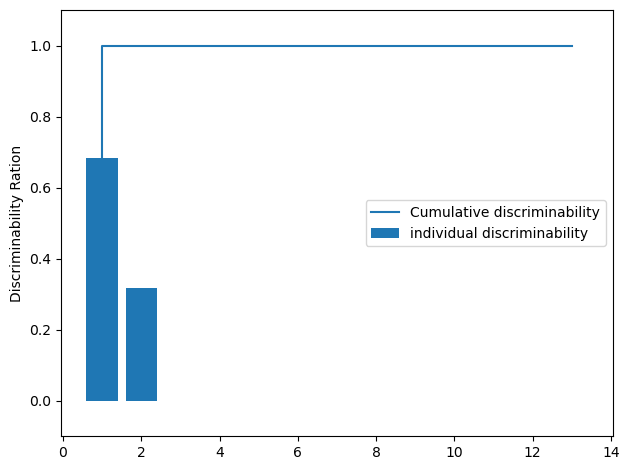

In [8]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real) 
discr = [(i/tot) for  i in sorted(eigen_vals.real, reverse=True)] 
cum_discr = np.cumsum(discr) 

plt.bar(range(1, 14), discr, label = 'individual discriminability') 
plt.step(range(1 ,14), cum_discr, label = 'Cumulative discriminability') 
plt.ylabel('Discriminability Ration') 
plt.ylim([-0.1, 1.1]) 
plt.legend() 
plt.tight_layout() 
plt.show()

In [9]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
            eigen_pairs[1][1][:, np.newaxis].real)) 
print('Matrix W:\n', w)

Matrix W:
 [[-0.1404 -0.4202]
 [ 0.0602 -0.1217]
 [ 0.006  -0.3427]
 [ 0.2332  0.273 ]
 [-0.012  -0.0278]
 [ 0.1879 -0.0886]
 [-0.7472  0.4535]
 [-0.0916  0.1452]
 [ 0.014   0.0678]
 [ 0.286  -0.2229]
 [-0.1073  0.2107]
 [-0.3536 -0.0019]
 [-0.3188 -0.5316]]


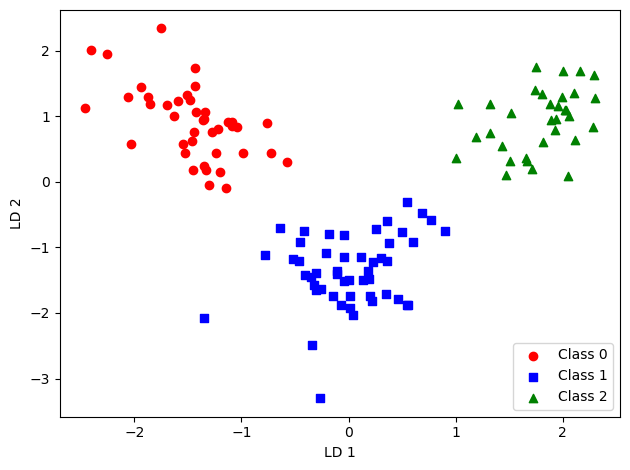

In [10]:
X_train_lda = X_train_std.dot(w)  # 降维投影

# 颜色和标记设置
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

# 绘图循环：每个类别分别画
for label, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == label, 0],        # LD 1
                X_train_lda[y_train == label, 1] * (-1),  # LD 2 反转（可选）
                c=color, label=f'Class {label}', marker=marker)

# 图形美化
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.multiclass import OneVsOneClassifier 
from sklearn.linear_model import LogisticRegression 
from  sklearn.metrics import accuracy_score

lda = LDA(n_components= 2) 

X_train_std_lda = lda.fit_transform(X_train_std, y_train) 
lr = OneVsOneClassifier(LogisticRegression(random_state= 1, solver='liblinear')) 
lr.fit(X_train_std_lda, y_train)
lr.score(X_train_std_lda, y_train)

1.0

In [12]:
X_test_lda = lda.transform(X_test) 
y_predict = lr.predict(X_test_lda)
accuracy_score(y_test, y_predict)

0.9629629629629629